<a href="https://colab.research.google.com/github/l-arkadiy-l/win_dca_strategy/blob/main/Arkadii_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [329]:
!pip install pandas

In [330]:
import pandas as pd
import numpy as np
from datetime import datetime

nik_data = pd.read_csv('nikkei_225.csv')
usdjpy_data = pd.read_csv('jpyusd.csv')
usdjpy_data.columns = ['Date'] + [usdjpy_data.columns[1]]

In [331]:
nik_data.columns = nik_data.iloc[0]

In [332]:
nik_data = nik_data.iloc[1:]

In [333]:
nik_data = nik_data.reset_index()

In [334]:
nik_data = nik_data.drop(columns=['Open', 'Volume'])

In [335]:
nik_data[nik_data['Price'].isna()]

Date,index,Price,Close,High,Low


In [336]:
usdjpy_data[usdjpy_data['DEXJPUS'].isna()]

,Date,DEXJPUS
29,1971-02-12,NaN
30,1971-02-15,NaN
105,1971-05-31,NaN
130,1971-07-05,NaN
160,1971-08-16,NaN
...,...,...
14063,2024-11-28,NaN
14082,2024-12-25,NaN
14087,2025-01-01,NaN
14100,2025-01-20,NaN


In [337]:
nan_mask = usdjpy_data["DEXJPUS"].isna()
usdjpy_data["group"] = (nan_mask != nan_mask.shift()).cumsum()  # Numbering the group
max_nan_streak = usdjpy_data[nan_mask].groupby("group").size().max()
print(f"Максимальная последовательность NaN: {max_nan_streak}")

Максимальная последовательность NaN: 11


We found that the maximum subsequence consisting of NaN values in the table is 11.

**There are two possible explanations:**

1. Either it's just a lucky sequence of holidays *(11 days)* during which it would have been physically impossible to make a deal;
2. Or the table simply isn't fully filled in.

Okay, so if we can find at least one working day in the table that is **not** a holiday, then the first option is immediately ruled out.


We find out that 1971-08-27 was a Friday. The stock markets should have been open on that day => So we'll proceed with our model, assuming that statement 2 is correct.

Since the maximum subsequence of NaNs is 11, we'll fill in the NaNs using a sliding window of length 12, i.e., 12 days.


In [338]:
usdjpy_data['DEXJPUS'] = usdjpy_data['DEXJPUS'].fillna(usdjpy_data['DEXJPUS'].rolling(window=12, min_periods=1).mean())

In [339]:
usdjpy_data[usdjpy_data['DEXJPUS'].isna()]

,Date,DEXJPUS,group


In [340]:
nik_data.columns = ['Date'] + nik_data.columns[1:].to_list()

In [341]:
data = pd.merge(nik_data, usdjpy_data, on='Date', how='inner')
data['Date'] = pd.to_datetime(data['Date'])

In [342]:
data = data[data['Date'].dt.dayofweek == 0] # Monday

In [343]:
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

/tmp/ipython-input-343-1184147733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price'] = pd.to_numeric(data['Price'], errors='coerce')


In [344]:
amount_investment = 100 # For ex we invest 100$ per week
total_units = 0
df_mondays = pd.DataFrame()
df_mondays['Investment_JPY'] = amount_investment * data['DEXJPUS']  # Convert $100 in JUS
df_mondays['Units_Bought'] = df_mondays['Investment_JPY'] / data['Price']  # Buy index units
total_invested = len(data) * amount_investment

In [345]:
def count_drawn(df, data):
    df['Cumulative_Units'] = df['Units_Bought'].cumsum()
    df['Portfolio_Value_JPY'] = df['Cumulative_Units'] * data['Price']
    df['Portfolio_Value_USD'] = df['Portfolio_Value_JPY'] / data['DEXJPUS']
    df['Max_Value'] = df['Portfolio_Value_USD'].cummax()
    df['Drawdown'] = df['Portfolio_Value_USD'] < df['Max_Value']
    df['Drawdown_pct'] = ((df['Max_Value'] - df['Portfolio_Value_USD']) / df['Max_Value']) * 100
    df['Average_Purchase_Price'] = df['Investment_JPY'].cumsum() / df['Units_Bought'].cumsum()


In [346]:
def show_info(df_ind, total_invested):
    total_units = df_ind['Units_Bought'].sum()
    last_price = data['Price'].iloc[-1]
    last_dexjpus = data['DEXJPUS'].iloc[-1]
    portfolio_value_jpy = total_units * last_price
    portfolio_value_usd = portfolio_value_jpy / last_dexjpus
    dollar_return = portfolio_value_usd - total_invested
    dollar_return_percent = (dollar_return / total_invested) * 100
    days_in_drawdown = df_ind['Drawdown'].sum()
    total_days = len(df_ind)
    drawdown_percent = (days_in_drawdown / total_days) * 100
    avg_purchase_price_usd = df_ind['Average_Purchase_Price'].iloc[-1] / last_dexjpus
    print(f"Total investment amount: ${total_invested:.2f}")
    print(f"Average purchase price (JPY): {df_ind['Average_Purchase_Price'].iloc[-1]:.2f}")
    print(f"Average purchase price (USD): ${avg_purchase_price_usd:.2f}")
    print(f"Portfolio value on the last day: ${portfolio_value_usd:.2f}")
    print(f"Dollar return: ${dollar_return:.2f} ({dollar_return_percent:.2f}%)")
    print(f"Number of Mondays in drawdown from ATH: {days_in_drawdown} out of {total_days}")
    print(f"Percentage of time in drawdown from ATH: {drawdown_percent:.2f}%")

In [347]:
df_mondays['Investment_JPY'] = amount_investment * data['DEXJPUS']
df_mondays['Units_Bought'] = df_mondays['Investment_JPY'] / data['Price']

total_invested = len(df_mondays) * amount_investment


count_drawn(df_mondays, data)
show_info(df_mondays, total_invested)

Total investment amount: $253200.00
Average purchase price (JPY): 8023.77
Average purchase price (USD): $54.53
Portfolio value on the last day: $1250494.06
Dollar return: $997294.06 (393.88%)
Number of Mondays in drawdown from ATH: 2192 out of 2532
Percentage of time in drawdown from ATH: 86.57%


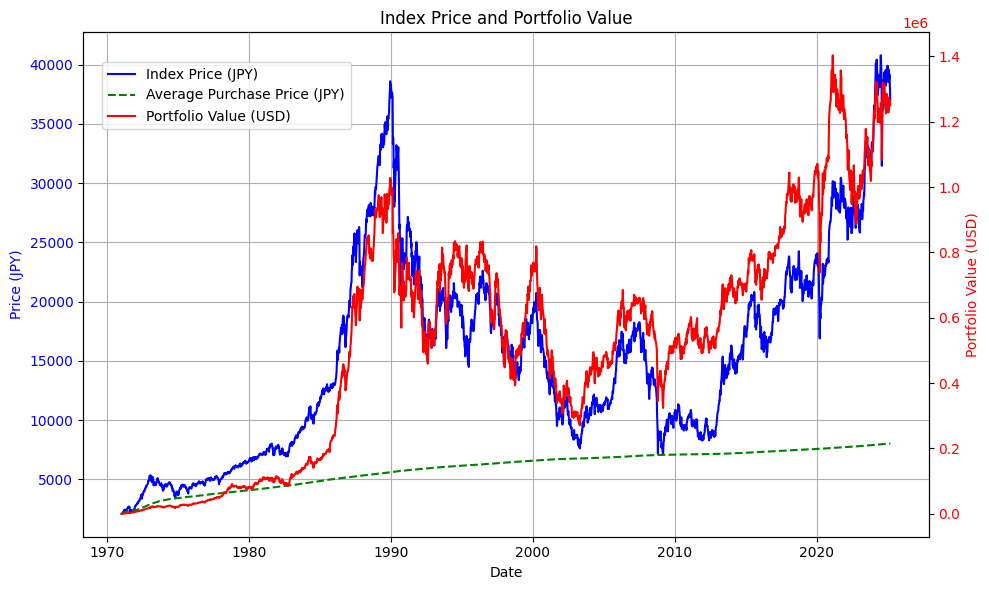

In [348]:
def draw_graph(df_ind, data):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(data['Date'], data['Price'], color='b', label='Index Price (JPY)')
    ax1.plot(data['Date'], df_ind['Average_Purchase_Price'], color='g', linestyle='--', label='Average Purchase Price (JPY)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (JPY)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(data['Date'], df_ind['Portfolio_Value_USD'], color='r', label='Portfolio Value (USD)')
    ax2.set_ylabel('Portfolio Value (USD)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Index Price and Portfolio Value')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()
    plt.show()
draw_graph(df_mondays, data)

Alright, now we know that the percentage of time we are in a Dollar return is 393%.

---

To increase this value, we will use the following strategies:
1. **Buy more of the index during drawdowns;**
2. **Market seasonality strategy;**
3. **MA26 strategy.**

# 1. Strategy: Buy more of the index during drawdowns;

In [349]:
df = pd.DataFrame()

In [350]:
df = pd.DataFrame()

df['ATH'] = data['Price'].cummax()  # ATH
df['Drawdown_from_ATH'] = (df['ATH'] - data['Price']) / df['ATH']
max_invest = 10000
min_invest = 80
precent_drawndown = 0.8
len_high_drawdown = len(df[df['Drawdown_from_ATH'] > precent_drawndown])
df['Investment_USD'] = np.where(df['Drawdown_from_ATH'] > precent_drawndown, max_invest, min_invest)

df['Investment_JPY'] = df['Investment_USD'] * data['DEXJPUS']
df['Units_Bought'] = df['Investment_JPY'] / data['Price']
total_invested = len_high_drawdown * max_invest + (len(df) - len_high_drawdown) * min_invest

In [351]:
len_high_drawdown

7

In [352]:
df['Investment_JPY'] = df['Investment_USD'] * data['DEXJPUS']  # Convert $100 in JPY
df['Units_Bought'] = df['Investment_JPY'] / data['Price']
total_invested = len_high_drawdown * max_invest + (len(df) - len_high_drawdown) * min_invest

In [353]:
count_drawn(df, data)

In [354]:
df[df['Drawdown_pct'] > 0]

,ATH,Drawdown_from_ATH,Investment_USD,Investment_JPY,Units_Bought,Cumulative_Units,Portfolio_Value_JPY,Portfolio_Value_USD,Max_Value,Drawdown,Drawdown_pct,Average_Purchase_Price
150,2698.270020,0.062184,80,28589.963636,11.298237,344.676231,8.721963e+05,2.440566e+03,2.517263e+03,True,3.046816,2406.233302
155,2698.270020,0.198082,80,28589.466667,13.212681,357.888912,7.743965e+05,2.166942e+03,2.517263e+03,True,13.916732,2397.282688
160,2698.270020,0.146153,80,28588.000000,12.408471,370.297383,8.531318e+05,2.387384e+03,2.517263e+03,True,5.159508,2394.153815
192,2698.270020,0.164213,80,26368.000000,11.692193,438.857328,9.897022e+05,3.002737e+03,3.093315e+03,True,2.928189,2387.495946
197,2698.270020,0.164765,80,26467.120000,11.743905,450.601233,1.015515e+06,3.069516e+03,3.093315e+03,True,0.769398,2384.008595
...,...,...,...,...,...,...,...,...,...,...,...,...
13299,40780.699219,0.055433,80,12374.400000,0.321245,4900.134110,1.887536e+08,1.220284e+06,1.388647e+06,True,12.124243,7900.309794
13304,40780.699219,0.048541,80,12137.600000,0.312815,4900.446925,1.901431e+08,1.253250e+06,1.388647e+06,True,9.750317,7902.282321
13308,40780.699219,0.039392,80,12246.981818,0.312628,4900.759554,1.919836e+08,1.254079e+06,1.388647e+06,True,9.690594,7904.277217
13317,40780.699219,0.073447,80,12012.800000,0.317921,4901.077475,1.851895e+08,1.233281e+06,1.388647e+06,True,11.188315,7906.215538


In [355]:
show_info(df, total_invested)

Total investment amount: $272000.00
Average purchase price (JPY): 7908.10
Average purchase price (USD): $53.74
Portfolio value on the last day: $1233368.60
Dollar return: $961368.60 (353.44%)
Number of Mondays in drawdown from ATH: 2180 out of 2532
Percentage of time in drawdown from ATH: 86.10%


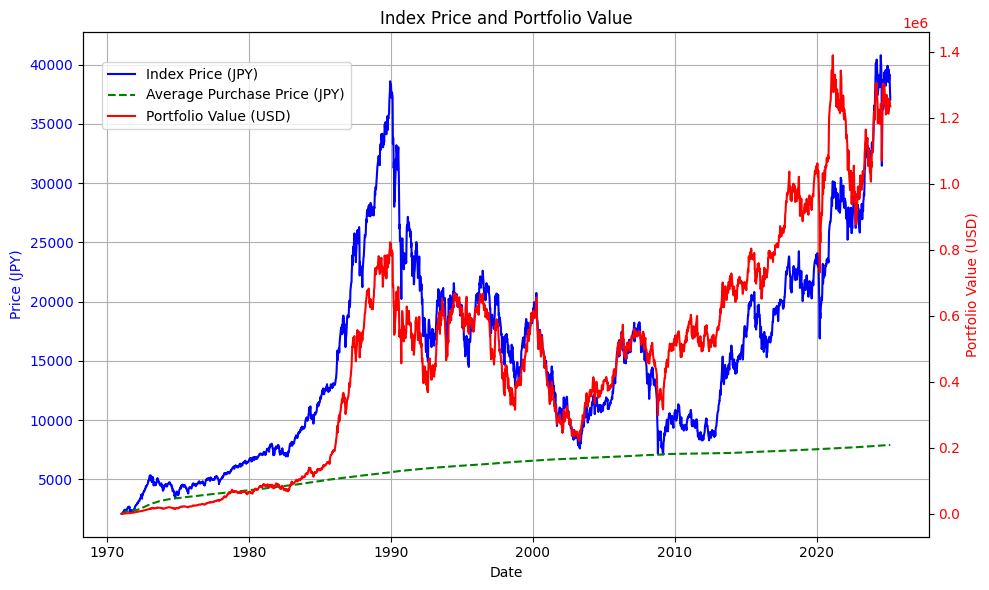

In [356]:
draw_graph(df, data)

**Result:**

    Cumulative return (spread between DCA strategies): -40%

    Percentage of time in drawdown from peak profit: 0.46%

# 2. Strategy: Market seasonality strategy;


 Market Seasonality. First, let's check if this seasonality actually exists. To do this, we will conduct a brief analysis:

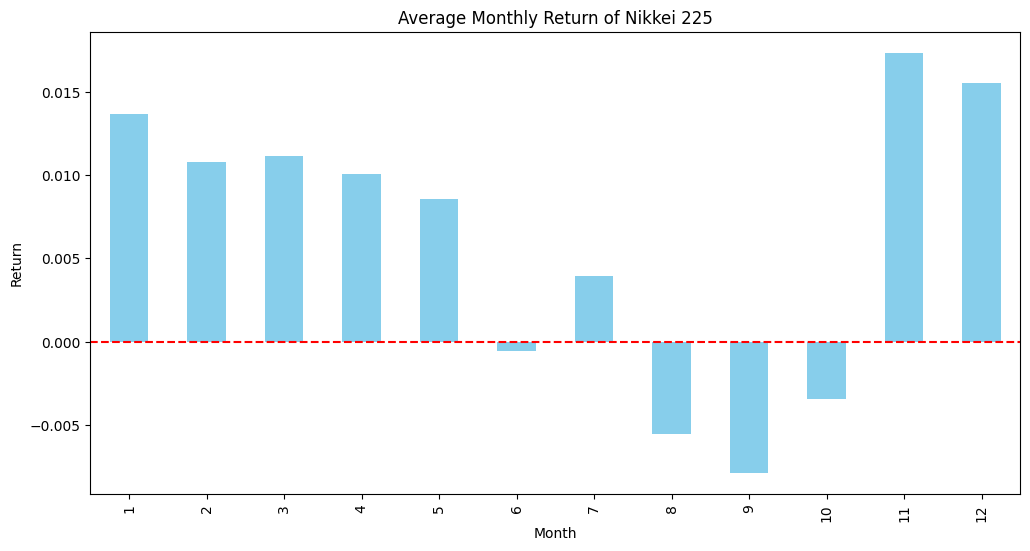

In [357]:
import matplotlib.pyplot as plt
df = data.copy()
df.set_index('Date', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
monthly_returns = df['Price'].resample('ME').last().pct_change()
season_analysis = monthly_returns.groupby(monthly_returns.index.month).agg(['mean', 'median', 'count'])
plt.figure(figsize=(12,6))
season_analysis['mean'].plot(kind='bar', color='skyblue')
plt.title('Average Monthly Return of Nikkei 225')
plt.xlabel('Month')
plt.ylabel('Return')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [358]:
!pip install scipy

In [359]:
from scipy import stats

# Split into "strong" and "weak" months
strong_months = [1, 2, 3, 4, 5, 11, 12]
weak_months = [6, 7, 8, 9, 10]
strong_returns = monthly_returns[monthly_returns.index.month.isin(strong_months)]
weak_returns = monthly_returns[monthly_returns.index.month.isin(weak_months)]

# T-test to check for differences
t_stat, p_value = stats.ttest_ind(strong_returns.dropna(), weak_returns.dropna())
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

T-statistic: 3.31, P-value: 0.0010


With a **T-statistic > 3**, the probability of differences between the average returns in "strong" and "weak" months is three standard deviations, indicating highly significant differences.

P = 0.001 implies a 0.10% chance that the difference occurred by chance.

Based on this data, it can be concluded that this strategy is definitely worth testing.

In [360]:
prob_strong = (strong_returns > 0).mean()
prob_weak = (weak_returns > 0).mean()

print(f"Probability of growth in strong months: {prob_strong:.2%}")
print(f"Probability of growth in weak months: {prob_weak:.2%}")

Probability of growth in strong months: 60.37%
Probability of growth in weak months: 49.63%


In [361]:
strong_invest = 80
weak_invest = 20

In [362]:
df_strategy_2 = pd.DataFrame()

In [363]:
data

,Date,Price,Close,High,Low,DEXJPUS,group
7,1971-01-18,2097.399902,2097.39990234375,2097.39990234375,2097.39990234375,358.290000,1
12,1971-01-25,2105.010010,2105.010009765625,2105.010009765625,2105.010009765625,357.730000,1
17,1971-02-01,2104.879883,2104.8798828125,2104.8798828125,2104.8798828125,357.670000,1
22,1971-02-08,2128.250000,2128.25,2128.25,2128.25,357.490000,1
26,1971-02-15,2166.639893,2166.639892578125,2166.639892578125,2166.639892578125,357.551000,2
...,...,...,...,...,...,...,...
13299,2025-02-03,38520.089844,38948.609375,38401.8203125,38932.66015625,154.680000,1077
13304,2025-02-10,38801.171875,38895.73828125,38606.3203125,38736.37109375,151.720000,1077
13308,2025-02-17,39174.250000,39238.75,39021.23046875,39094.08984375,153.087273,1078
13317,2025-03-03,37785.468750,37827.62109375,37372.26171875,37617.5,150.160000,1079


In [364]:
data['Month'] = pd.to_datetime(data['Date']).dt.month

In [365]:
df_strategy_2['Month'] = data['Month']
mask = df_strategy_2['Month'].isin(strong_months)

In [366]:
df_strategy_2['Investment_USD'] = np.where(mask, strong_invest, weak_invest)

In [367]:
len_month_strong = len(data[mask])

In [368]:
len(df_strategy_2)

2532

In [369]:
df_strategy_2['Investment_JPY'] = data['DEXJPUS'].values * df_strategy_2['Investment_USD']
df_strategy_2['Units_Bought'] = df_strategy_2['Investment_JPY'] / data['Price'].values

In [370]:
df_strategy_2.head()

,Month,Investment_USD,Investment_JPY,Units_Bought
7,1,80,28663.20,13.666063
12,1,80,28618.40,13.595375
17,2,80,28613.60,13.593935
22,2,80,28599.20,13.437895
26,2,80,28604.08,13.202046


In [371]:
total_invested = len_month_strong * strong_invest + (len(df_strategy_2) - len_month_strong) * weak_invest

In [372]:
count_drawn(df_strategy_2, data)

In [373]:
show_info(df_strategy_2, total_invested)

Total investment amount: $137940.00
Average purchase price (JPY): 7985.59
Average purchase price (USD): $54.27
Portfolio value on the last day: $682961.82
Dollar return: $545021.82 (395.12%)
Number of Mondays in drawdown from ATH: 2207 out of 2532
Percentage of time in drawdown from ATH: 87.16%


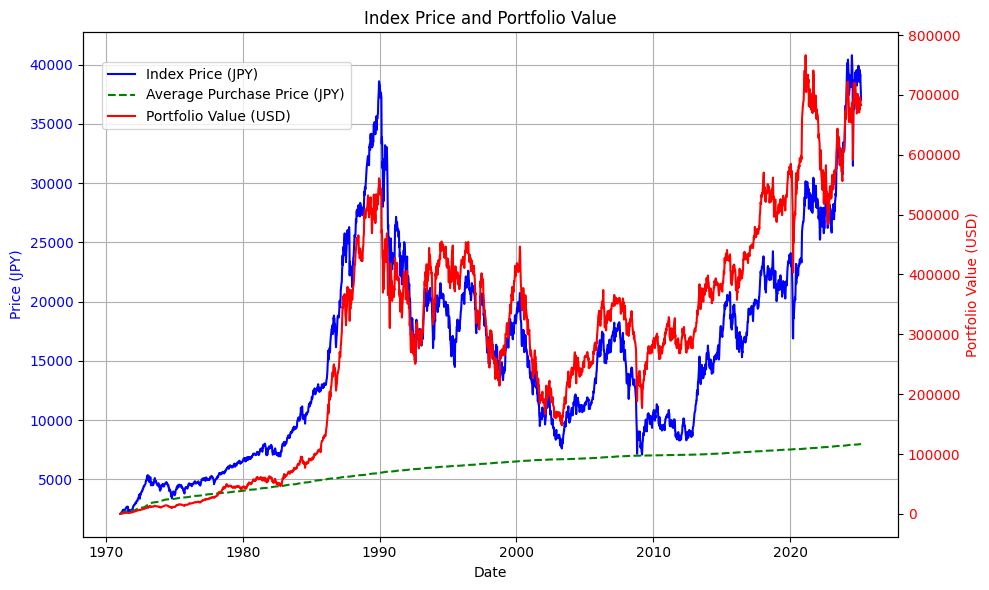

In [374]:
draw_graph(df_strategy_2, data)

**Result:**

    Cumulative return (spread between DCA strategies): +2%

    Percentage of time in drawdown from peak profit: 0.5%

*What could be the reason for such a low increase in profitability?*

In fact, this is quite strange, as even the yen strengthened against the dollar. Yes, it’s possible that in the months when we bought more of the index, the yen was falling, which offset our profits. However, the likelihood that this happened consistently over 50+ years is extremely low.

In [375]:
arr = data['DEXJPUS'].values

In [376]:
arr[0]

np.float64(358.29)

In [377]:
# Calculate the change
depreciation_pct = ((arr[0] - arr[-1]) / arr[-1]) * 100

print(f'{depreciation_pct:.0f}%') # this is the percentage change in the yen over the given period

143%


# 3. MA26 strategy


In [378]:
df = pd.DataFrame()
df['MA26'] = data['Price'].rolling(window=26).mean()
df['Deviation'] = (data['Price'] - df['MA26']) / df['MA26']

# Strategy parameters
invest_deep_drop = 10   # $10, if price is 15% or more below MA26
invest_mild_drop = 20   # $20, if price is below MA26 but deviation < 15%
invest_above_ma = 90     # $90, if price is at or above MA26

# Calculate investments
df['Investment_USD'] = np.where(df['MA26'].isna(), invest_above_ma,
                                np.where(df['Deviation'] < -0.15, invest_deep_drop,
                                         np.where(df['Deviation'] < 0, invest_mild_drop, invest_above_ma)))
df['Investment_JPY'] = df['Investment_USD'] * data['DEXJPUS']
df['Units_Bought'] = df['Investment_JPY'] / data['Price']
total_invested = df['Investment_USD'].sum()

# Perform calculations and display results
count_drawn(df, data)
show_info(df, total_invested)

Total investment amount: $159250.00
Average purchase price (JPY): 7888.10
Average purchase price (USD): $53.61
Portfolio value on the last day: $832499.23
Dollar return: $673249.23 (422.76%)
Number of Mondays in drawdown from ATH: 2207 out of 2532
Percentage of time in drawdown from ATH: 87.16%


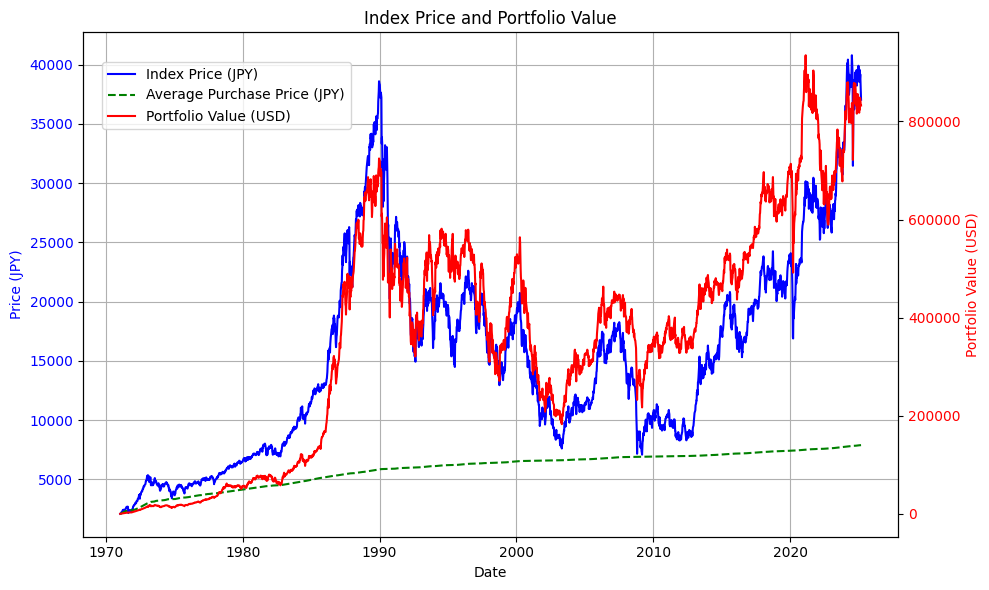

In [379]:
draw_graph(df, data)

**Result:**

    Cumulative return (spread between DCA strategies): +30%

    Percentage of time in drawdown from peak profit: -0.5%